# Reduced Ion Velocity Distribution Function using Monte-Carlo integration

author: Louis Richard\
Example to compute and plot reduced ion distributions from FPI

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from pyrfu import mms, pyrf
from pyrfu.plot import plot_spectr, plot_line, use_pyrfu_style

use_pyrfu_style(usetex=True)

Load IGRF coefficients ...


## Load data

### Define time interval and spacecraft index

In [ ]:
mms.db_init(default="local", local="/data/mms")
tint = ["2015-12-28T03:57:10", "2015-12-28T03:59:00"]
mms_id = 2

[12-Mar-24 14:38:32] INFO: Updating MMS data access configuration in /usr/local/lib/python3.11/site-packages/pyrfu/mms/config.json...
[12-Mar-24 14:38:32] INFO: Updating MMS SDC credentials in /Users/louisr/.config/python_keyring...


### Get magnetic field in spacecraft coordinates

In [3]:
b_dmpa = mms.get_data("b_dmpa_fgm_brst_l2", tint, mms_id)

[12-Mar-24 14:38:32] INFO: Loading mms2_fgm_b_dmpa_brst_l2...


### Get spacecraft attitude (for conversion between Geocentric Solar Ecliptic to spacecrat coordinates)

In [4]:
defatt = mms.load_ancillary("defatt", tint, mms_id)

[12-Mar-24 14:38:33] INFO: Loading ancillary defatt files...
[12-Mar-24 14:38:33] WARNING: /usr/local/lib/python3.11/site-packages/pyrfu/mms/load_ancillary.py:84: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  rows = pd.read_csv(

[12-Mar-24 14:38:35] WARNING: /usr/local/lib/python3.11/site-packages/pyrfu/mms/load_ancillary.py:84: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  rows = pd.read_csv(

[12-Mar-24 14:38:36] WARNING: /usr/local/lib/python3.11/site-packages/pyrfu/mms/load_ancillary.py:84: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  rows = pd.read_csv(

[12-Mar-24 14:38:38] WARNING: /usr/local/lib/python3.11/site-packages/pyrfu/mms/load_ancillary.py:84: FutureWarning: The 'delim_whitespace

### Get the ion velocity distribution skymap and the uncertainties ($\delta f / f = 1/\sqrt{n}$ with $n$ the number of counts)

In [5]:
vdf_i = mms.get_data("pdi_fpi_brst_l2", tint, mms_id)
vdf_i_err = mms.get_data("pderri_fpi_brst_l2", tint, mms_id)

[12-Mar-24 14:38:40] INFO: Loading mms2_dis_dist_brst...
[12-Mar-24 14:38:40] INFO: Loading mms2_dis_disterr_brst...


### Ignore phase-space density for one count level (also makes function faster)

In [6]:
vdf_i.data.data[vdf_i.data.data < 1.1 * vdf_i_err.data.data] = 0.0

### 

## Define the coordinates system for projection of the distribution function

### Shock normal vector in GSE (get this from irf_shock_normal or irf_shock_gui)

In [7]:
n_vec = np.array([0.9580, -0.2708, -0.0938])
n_vec /= np.linalg.norm(n_vec)

### Upstream magnetic field in GSE


In [8]:
b_u = [-1.0948, -2.6270, 1.6478]

### $t_2$ vector in GSE (same vectors as in [Johlander et al. 2016, PRL])

In [9]:
t2_vec = np.cross(n_vec, b_u) / np.linalg.norm(np.cross(n_vec, b_u))

### $t_1$ vector in GSE


In [10]:
t1_vec = np.cross(t2_vec, n_vec)

### Construct the time series for $n$, $t_1$, and $t_2$

In [11]:
n_t = len(b_dmpa.time.data)
n_gse = pyrf.ts_vec_xyz(b_dmpa.time.data, np.tile(n_vec[np.newaxis, :], [n_t, 1]))
t1_gse = pyrf.ts_vec_xyz(b_dmpa.time.data, np.tile(t1_vec[np.newaxis, :], [n_t, 1]))
t2_gse = pyrf.ts_vec_xyz(b_dmpa.time.data, np.tile(t2_vec[np.newaxis, :], [n_t, 1]))

### Transform the vectors into spacecraft coordinates using the spacecraft attitude

In [12]:
n_dmpa = mms.dsl2gse(n_gse, defatt)
t1_dmpa = mms.dsl2gse(t1_gse, defatt)
t2_dmpa = mms.dsl2gse(t2_gse, defatt)

### Create the transformation matrices from spacecraft coordinates

In [13]:
nt1t2 = np.transpose(np.stack([n_dmpa.data, t1_dmpa.data, t2_dmpa.data]), [1, 2, 0])
nt1t2 = pyrf.ts_tensor_xyz(b_dmpa.time.data, nt1t2)

t1t2n = np.transpose(np.stack([t1_dmpa.data, t2_dmpa.data, n_dmpa.data]), [1, 2, 0])
t1t2n = pyrf.ts_tensor_xyz(b_dmpa.time.data, t1t2n)

t2nt1 = np.transpose(np.stack([t2_dmpa.data, n_dmpa.data, t1_dmpa.data]), [1, 2, 0])
t2nt1 = pyrf.ts_tensor_xyz(b_dmpa.time.data, t2nt1)

### Define velocity grid along the three vectors

In [14]:
vn_lim = np.array([-800.0, 800.0], dtype=np.float64)
vt1_lim = vn_lim
vt2_lim = vn_lim + 300.0

vg_1d_n = 1e3 * np.linspace(vn_lim[0], vn_lim[1], 100)
vg_1d_t1 = 1e3 * np.linspace(vt1_lim[0], vt1_lim[1], 100)
vg_1d_t2 = 1e3 * np.linspace(vt2_lim[0], vt2_lim[1], 100)

### Reduce distribution along the three vectors

In [15]:
n_mc = 200

f1dn = mms.reduce(vdf_i, projection_dim="1d", xyz=nt1t2, n_mc=n_mc, vg=vg_1d_n)
f1dt1 = mms.reduce(vdf_i, projection_dim="1d", xyz=t1t2n, n_mc=n_mc, vg=vg_1d_t1)
f1dt2 = mms.reduce(vdf_i, projection_dim="1d", xyz=t2nt1, n_mc=n_mc, vg=vg_1d_t2)

[12-Mar-24 14:38:41] INFO: Using averages in resample
100%|█████████████████████| 733/733 [00:39<00:00, 18.62it/s]
[12-Mar-24 14:39:20] INFO: Using averages in resample
100%|█████████████████████| 733/733 [00:39<00:00, 18.51it/s]
[12-Mar-24 14:40:00] INFO: Using averages in resample
100%|█████████████████████| 733/733 [00:33<00:00, 21.69it/s]


### Plot

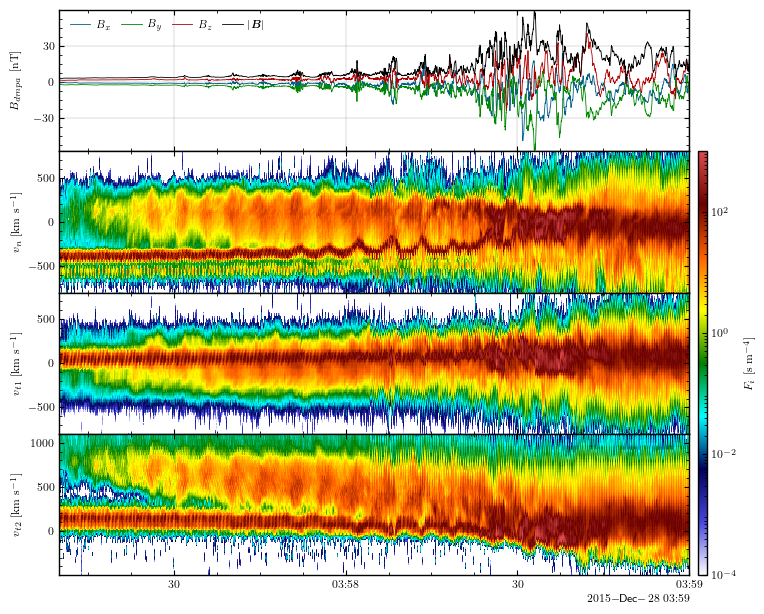

In [16]:
f, axs = plt.subplots(4, sharex="all", figsize=(9, 6.5))
f.subplots_adjust(hspace=0.0, left=0.15, right=0.85, bottom=0.08, top=0.95)

plot_line(axs[0], b_dmpa)
plot_line(axs[0], pyrf.norm(b_dmpa), color="k")
axs[0].legend([r"$B_{x}$", r"$B_{y}$", r"$B_{z}$", r"$|\bm{B}|$"], ncol=4)
axs[0].set_ylabel("$B_{dmpa}~[\mathrm{nT}]$")

axs[1], cax1 = plot_spectr(axs[1], f1dn, cscale="log", clim=[1e-4, 1e3])
axs[1].set_ylim(vn_lim)
axs[1].set_ylabel("$v_n~[\\mathrm{km}~\\mathrm{s}^{-1}]$")
axs[1].set_yticks([-500.0, 0.0, 500.0])

axs[2] = plot_spectr(axs[2], f1dt1, cscale="log", clim=[1e-4, 1e3], colorbar="none")
axs[2].set_ylim(vt1_lim)
axs[2].set_ylabel("$v_{t1}~[\\mathrm{km}~\\mathrm{s}^{-1}]$")
axs[2].set_yticks([-500.0, 0.0, 500.0])

axs[3] = plot_spectr(axs[3], f1dt2, cscale="log", clim=[1e-4, 1e3], colorbar="none")
axs[3].set_ylim(vt2_lim)
axs[3].set_ylabel("$v_{t2}~[\\mathrm{km}~\\mathrm{s}^{-1}]$")
axs[3].set_yticks([0.0, 500.0, 1000.0])

pos_axs3 = axs[3].get_position()
pos_cax1 = cax1.get_position()
x0 = pos_cax1.x0
y0 = pos_axs3.y0
width = pos_cax1.width
height = pos_cax1.y0 + pos_cax1.height - y0
cax1.set_position([x0, y0, width, height])

cax1.set_ylabel("$F_i~[\\mathrm{s}~\\mathrm{m}^{-4}]$")
f.align_ylabels(axs)

## 

## 2D projection of the ion velocity distribution functions

### Define the center time $\pm 1~\mathrm{s}$ (to average the distributions)

In [17]:
t_2d = np.datetime64("2015-12-28T03:57:40.300")
t_2d = pyrf.extend_tint([t_2d, t_2d], [-1, 1])

### Define the velocity grid for 2D projection

In [18]:
vg_2d = np.linspace(-1500, 1500, 200) * 1e3

### Reduce ion distributions in 2d planes $(n, t_1)$, $(t_2, n)$, and $(t_1, t_2)$

In [19]:
f2Dnt1 = mms.reduce(
    pyrf.time_clip(vdf_i, t_2d),
    xyz=nt1t2,
    dim="2d",
    base="cart",
    n_mc=n_mc * 5,
    vg=vg_2d,
)
f2Dt2n = mms.reduce(
    pyrf.time_clip(vdf_i, t_2d),
    xyz=t2nt1,
    dim="2d",
    base="cart",
    n_mc=n_mc * 5,
    vg=vg_2d,
)
f2Dt1t2 = mms.reduce(
    pyrf.time_clip(vdf_i, t_2d),
    xyz=t1t2n,
    dim="2d",
    base="cart",
    n_mc=n_mc * 5,
    vg=vg_2d,
)

[12-Mar-24 14:40:36] INFO: Using averages in resample
100%|███████████████████████| 13/13 [00:04<00:00,  2.69it/s]
[12-Mar-24 14:40:41] INFO: Using averages in resample
100%|███████████████████████| 13/13 [00:03<00:00,  4.29it/s]
[12-Mar-24 14:40:44] INFO: Using averages in resample
100%|███████████████████████| 13/13 [00:03<00:00,  4.25it/s]


### Plot

Text(0.5, 0, '$F_i~[\\mathrm{s}^2~\\mathrm{m}^{-5}]$')

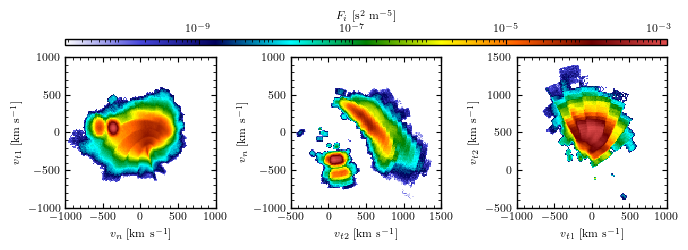

In [20]:
f, axs = plt.subplots(1, 3, figsize=(7, 3.0))
f.subplots_adjust(wspace=0.5, left=0.11, right=0.97, bottom=0.2, top=0.78)
axs[0], cax0 = plot_spectr(axs[0], f2Dnt1.mean(axis=0), cscale="log", colorbar="top")
axs[0].set_xlim([-1e3, 1e3])
axs[0].set_ylim([-1e3, 1e3])
axs[0].set_aspect("equal")
axs[0].set_xlabel("$v_{n}~[\\mathrm{km}~\\mathrm{s}^{-1}]$")
axs[0].set_ylabel("$v_{t1}~[\\mathrm{km}~\\mathrm{s}^{-1}]$")

axs[1] = plot_spectr(axs[1], f2Dt2n.mean(axis=0), cscale="log", colorbar="none")
axs[1].set_xlim([-0.5e3, 1.5e3])
axs[1].set_ylim([-1e3, 1e3])
axs[1].set_aspect("equal")
axs[1].set_xlabel("$v_{t2}~[\\mathrm{km}~\\mathrm{s}^{-1}]$")
axs[1].set_ylabel("$v_{n}~[\\mathrm{km}~\\mathrm{s}^{-1}]$")

axs[2] = plot_spectr(axs[2], f2Dt1t2.mean(axis=0), cscale="log", colorbar="none")
axs[2].set_xlim([-1e3, 1e3])
axs[2].set_ylim([-0.5e3, 1.5e3])
axs[2].set_aspect("equal")
axs[2].set_xlabel("$v_{t1}~[\\mathrm{km}~\\mathrm{s}^{-1}]$")
axs[2].set_ylabel("$v_{t2}~[\\mathrm{km}~\\mathrm{s}^{-1}]$")

pos_axs2 = axs[2].get_position()
pos_cax0 = cax0.get_position()
x0 = pos_cax0.x0
y0 = pos_cax0.y0 - 0.01
width = pos_axs2.x0 + pos_axs2.width - pos_cax0.x0
height = 0.02
cax0.set_position([x0, y0, width, height])

cax0.set_xlabel("$F_i~[\\mathrm{s}^2~\\mathrm{m}^{-5}]$")